In [4]:
%matplotlib inline

#Loading in the necessary packages
import numpy as np
import gausspy
import gausspy.gp as gp
from astropy.modeling.models import Voigt1D
from astropy.io import fits
from matplotlib import pyplot as plt
import pickle
import warnings
##added imports from Binary Plots
    ##P2.7 didn't have pathlib so I downloaded it and now it works!!
from pathlib import Path
import os.path
import pandas as pd



warnings.simplefilter(action='ignore', category=FutureWarning)

##This is our GAUSSIAN fcn
    ##INPUTS: amplitude, full-width half-maximum, and the average
    ##OUTPUTS: a calculated value for x
def gaussian(amp, fwhm, mean):
    ##LAMBDA is a fancy way of returning the result of the calculation
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)


In [25]:
#This is the function for converting lags to RV in km/s

#INPUT: lag value, vhelio value
#OUTPUT: radial velocity in km/s

def lagToRV(lag, vh):
    c = 2.9972*10**(5)
    rv_kms = (10**(6*10**(-6)*lag)-1)*c+vh
    return rv_kms

#This is the function for propagting the means fit error 
#through the RV conversion

#INPUT: index
#OUTPUT means fit error in km/s

def errPropagate(index):
    c = 2.9972*10**(5)
    small = (6*10**(-6))
    constants = np.log(10)*small*c
    lag = float(frame['means fit'][index])
    variables = 10**(small*lag)
    dl = float(frame['means fit error'][index])
    rvError = constants*variables*dl
    return rvError

In [26]:
#print np.log(10)
print frame['means fit'][1], frame['means fit error'][1]
print errPropagate(1)

37.255550032642944 1.3050838296397607
5.406853531859867


In [6]:
#frame.to_csv(r'\Volumes\CoveyData\APOGEE_Spectra\Chase\eclbin\lagsAndNames.csv')

# Now I want to convert from lag to RVs in km/s
# The tricky part is I have 1-2 lags for each visit
#BUT I think it's best to just see if I can access and convert one 
#entry successfully and then apply that to the rest

RV = (10**(6*10**(-6)*2.189814882572316)-1)*(2.99792*10**(5))+(-40.9385)
print "2M00224443+8448486's Radial velocity is", RV, "km/s"


2M00224443+8448486's Radial velocity is -31.8686323238 km/s


In [7]:
#Lag is what you have been plotting on the x axis, I think you can leave it unchanged
lag=np.array(range(-300,301))
lag1=np.array(range(-200,201))
err=np.ones(601)*0.05

#Data is the structure that we will be filling up
data = {}

##file reader copied from Binary Plots
eclbin = pd.read_csv('apogee_binaries_ChaseNotes1.csv')
##testcode for checking that the excel column is formatted tight and is being read
    ##print(eclbin['ChaseVisual'])
    
##where in the array--column ChaseVisual--do we have values equal to 1
    ##aka find me the clean binaries AND put them in an array/list
a=np.where(eclbin['ChaseVisual'] ==1)[0]
#a.append(np.where(eclbin['ChaseVisual']==1)[0])
##tells me how many clean binaries there are in that new arrray/list
print len(a)

#Instead of ccfall, get the epoch ccf you are using - should probably do it inside the
#nested for loop, in the same way it is defined in the plotting statement so far
#for i in range(len(ccfall)): replaced with code pasted from Binary Plots
totVisits = 0
##For every binary in the list
i=-1
objid=[]
#mjd=[]
for j in a:
    ##print the value plus 2??
    #print(j+2)
    ##looking at nvisits column at the row of our specific binary
    ##assign that number of visits to this variable 'nvisits'
    #"""changed eclbin['nvisits'] to eclbin['trueVisit']"""
    nvisits=eclbin['nvisits'][j]
    ##looking at filename column and saving name as a string to variable 'my_file'
    my_file = Path(str(eclbin['filename'][j]))
    ##opening the file with a fitting module
    d = fits.open(my_file)
    ##probably something to do with astropy or gausspy?
    point = d[9]
    #print point.data[0][29]
    #print point.data[0]['VHELIO']
    xccf = point.data[0][29] # Proper location of x values of the CCF
    xccf=(10**(xccf*6e-6)-1)*2.99792458e5
    CCF = point.data[0][27]
    ##closing the module
    
    ##Now iterating over each visit for a specific binary
    for visit in range(0,nvisits):
        #if binary has one visit
        if nvisits == 1:
            #set totVisits value to 1
            #AND ccf for this visit == only CCF from .fits file
            totVisits = totVisits + 1
            ccf = CCF
        #if binary has >1 visit
        else:
            #add one to visit counter
            #ccf for this visit  == particular CCF from .fits file
            totVisits = totVisits + 1
            ccf = CCF[visit+2]
        #basically a boolean, to distinguish nonzero values from zeroes
        nonzeroes = np.count_nonzero(ccf)
        
        #if it's not zero
        if nonzeroes >= 1:
            #[difference?] = math stuff
            diff=np.max(np.array([(np.max(ccf))*0.2,np.median(ccf)]))
            #updated ccf for this visit = ccf for this visit - diff
            ccf=ccf-diff
            #make a list of set dimension filled with zeros
            a=np.zeros(100).tolist()
            #adds each item in the ccf to the list?
            a.extend(ccf)
            a.extend(np.zeros(100).tolist())
            a=np.array(a)
            data['data_list'] = data.get('data_list', []) + [a]
            data['x_values'] = data.get('x_values', []) + [lag]
            data['errors'] = data.get('errors', []) + [err]
            objid.append(eclbin['apogee_id'][j])

print 'stop'

FILENAME = 'training_data_sb2.pickle'
pickle.dump(data, open(FILENAME, 'w'))


54
stop


In [8]:
# Decompose multiple Gaussian dataset using AGD with TRAINED alpha
import pickle
import gausspy.gp as gp

# Specify necessary parameters
###THIS IS THE ONE I'M MESSING WITH
alpha1 = +1

snr_thresh = 4.

FILENAME_DATA = 'training_data_sb2.pickle'
FILENAME_DATA_DECOMP = 'sb2_decomposed_full.pickle'

# Load GaussPy
g = gp.GaussianDecomposer()

# Setting AGD parameters
g.set('phase', 'one')
g.set('SNR_thresh', [snr_thresh, snr_thresh])
g.set('alpha1', alpha1)

# Run GaussPy
#if set verbose to false it won't print out
data_decomp = g.batch_decomposition(FILENAME_DATA,verbose=True)

# Save decomposition information
pickle.dump(data_decomp, open(FILENAME_DATA_DECOMP, 'w'))

print 'stop'

   ---->   0
   ---->   8
   ---->   16
   ---->   24
   ---->   9
   ---->   17
   ---->   1
   ---->   25
   ---->   10
   ---->   18
   ---->   26
   ---->   2
   ---->   11
   ---->   27
   ---->   19
   ---->   3
   ---->   28
   ---->   20
   ---->   12
   ---->   29
   ---->   21
   ---->   4
   ---->   13
   ---->   30
   ---->   14
   ---->   5
   ---->   31
   ---->   22
   ---->   15
   ---->   32
   ---->   6
   ---->   33
   ---->   23
   ---->   7
   ---->   40
   ---->   34
   ---->   48
   ---->   56
   ---->   41
   ---->   35
   ---->   57
   ---->   49
   ---->   42
   ---->   58
   ---->   36
   ---->   50
   ---->   43
   ---->   37
   ---->   59
   ---->   51
   ---->   44
   ---->   38
   ---->   60
   ---->   52
   ---->   45
   ---->   39
   ---->   61
   ---->   53
   ---->   46
   ---->   64
   ---->   47
   ---->   54
   ---->   62
   ---->   65
   ---->   55
   ---->   72
   ---->   63
   ---->   66
   ---->   80
   ---->   73
   ---->   88
   ---->   67
  

1


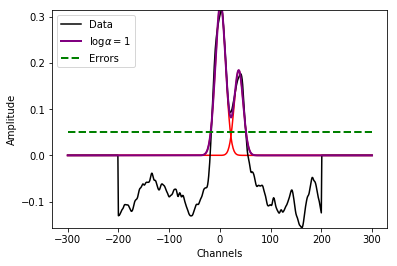

2


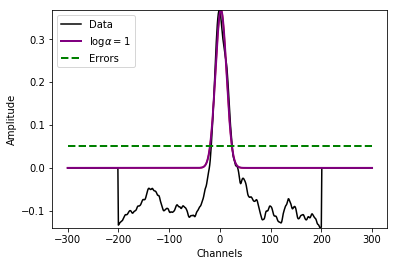

3


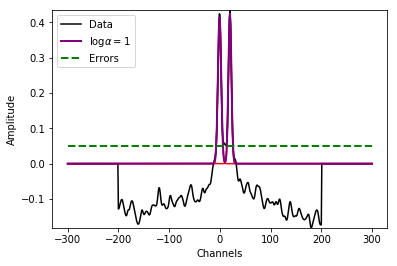

4


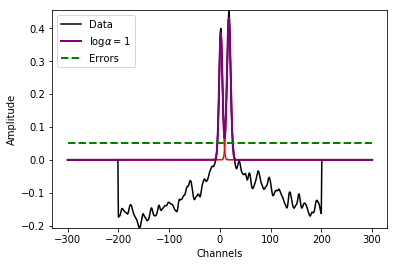

5


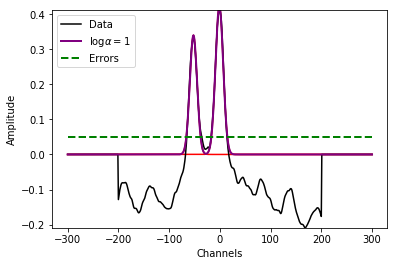

6


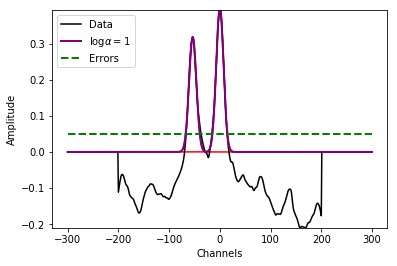

7


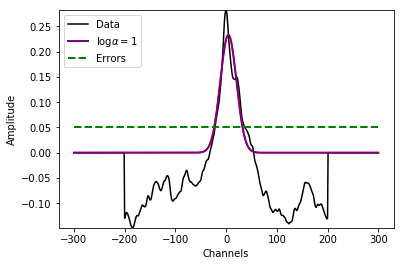

8


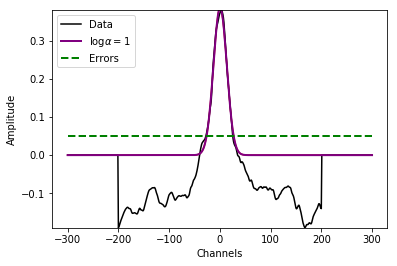

9


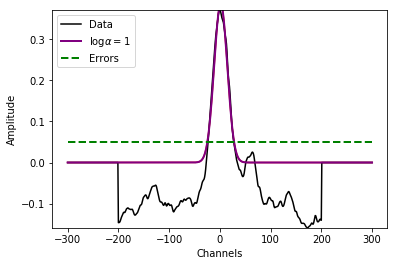

10


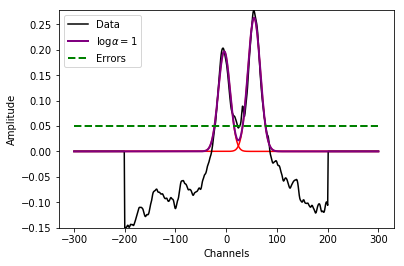

11


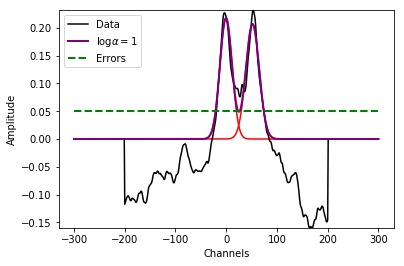

12


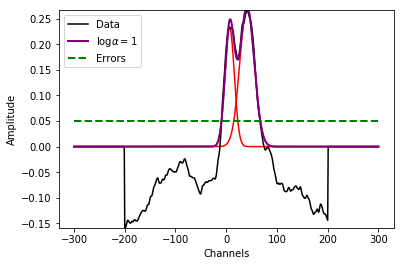

13


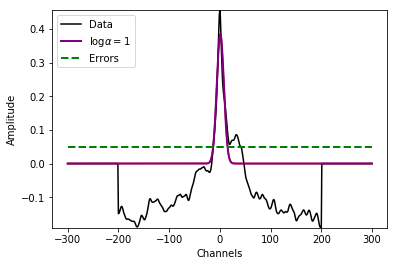

14


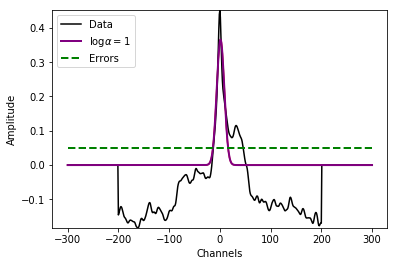

15


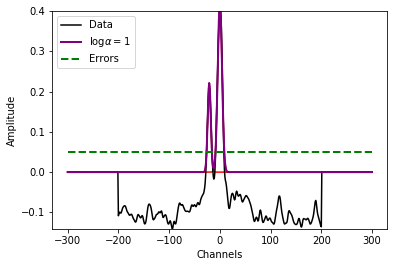

16


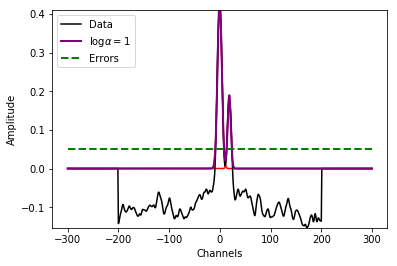

17


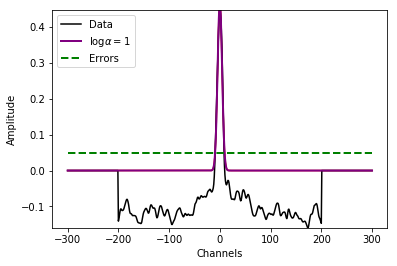

18


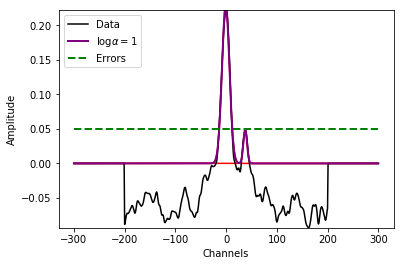

19


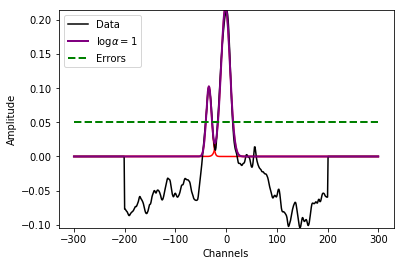

20


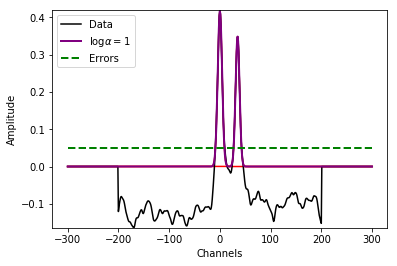

21


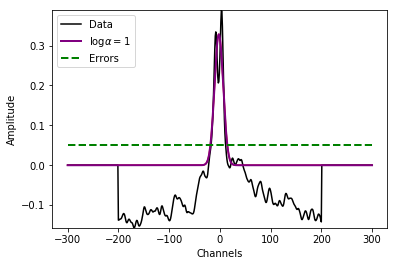

22


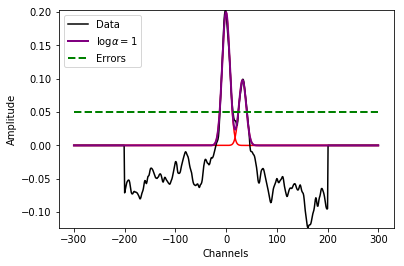

23


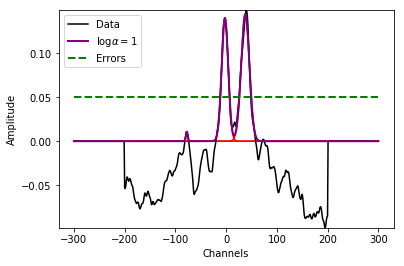

24


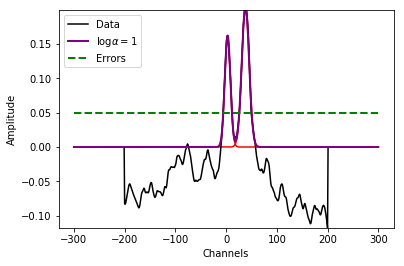

25


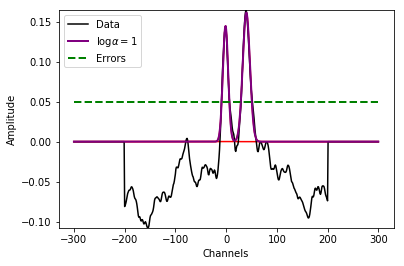

26


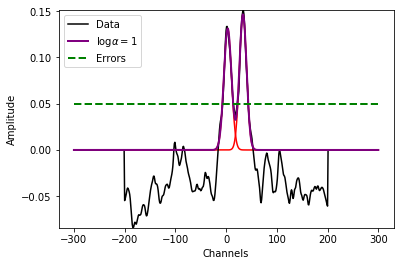

27


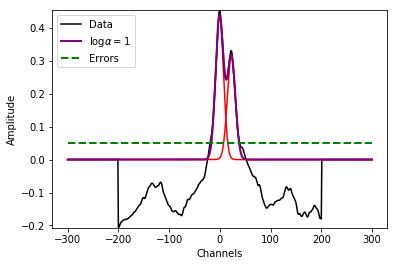

28


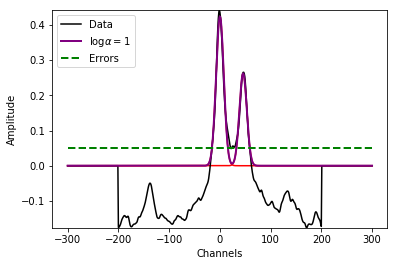

29


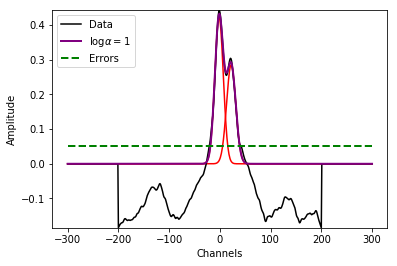

30


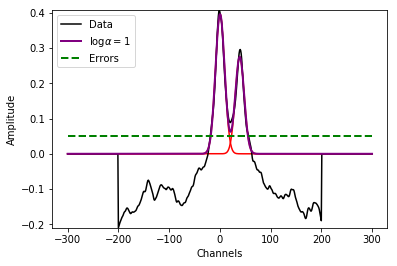

31


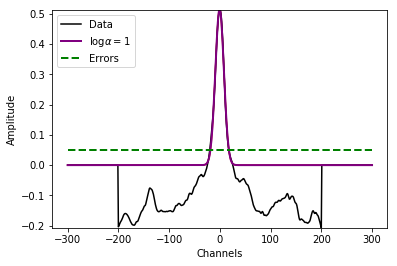

32


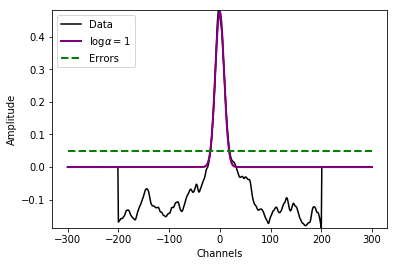

33


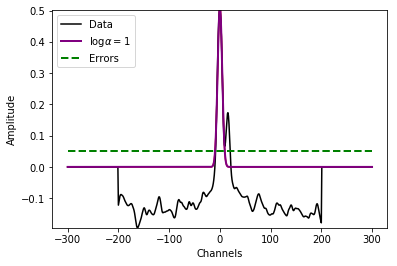

34


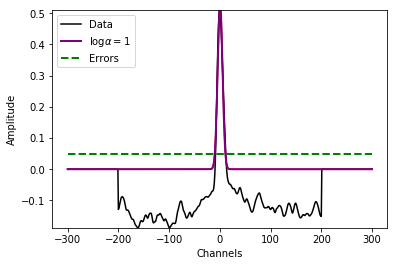

35


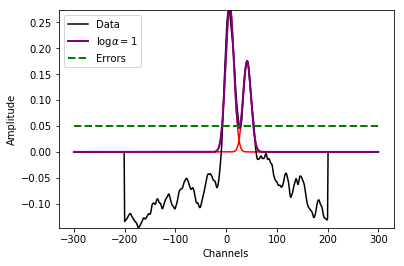

36


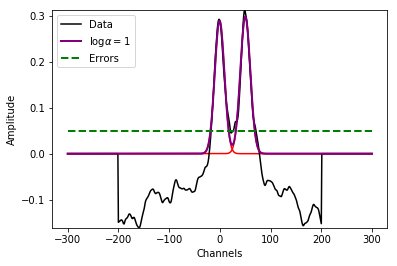

37


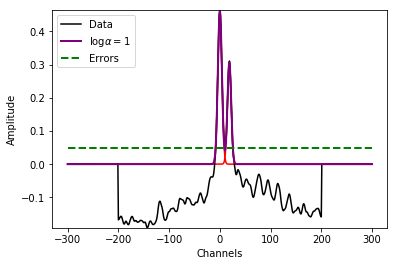

38


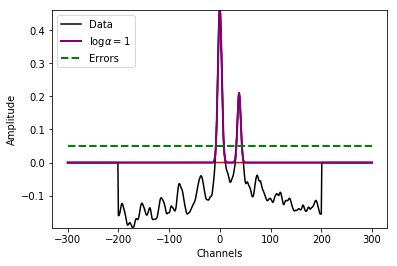

39


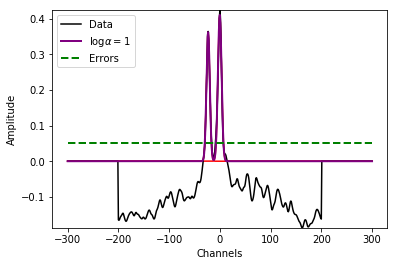

40


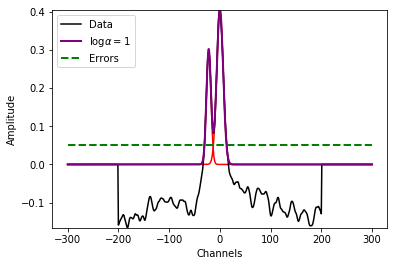

41


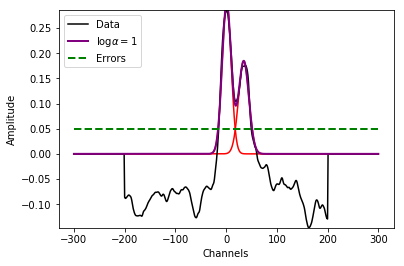

42


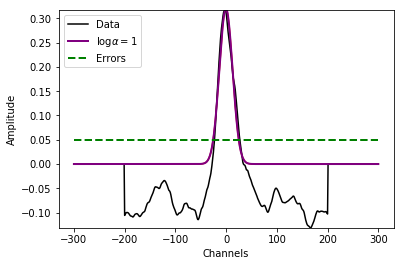

43


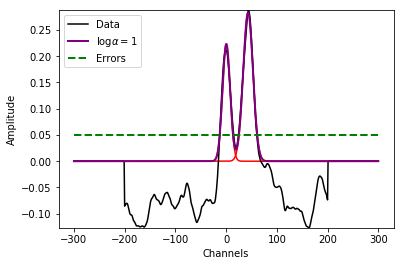

44


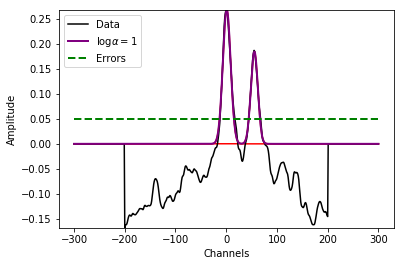

45


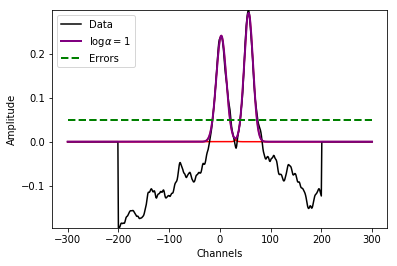

46


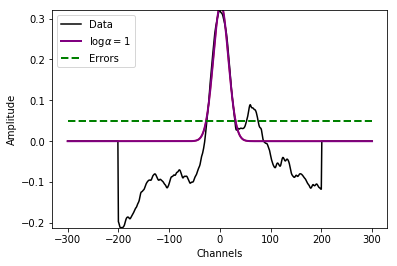

47


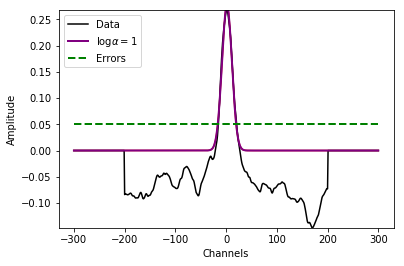

48


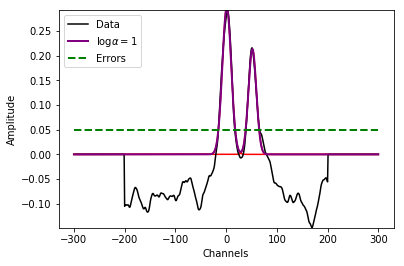

49


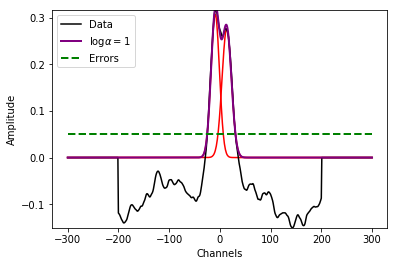

50


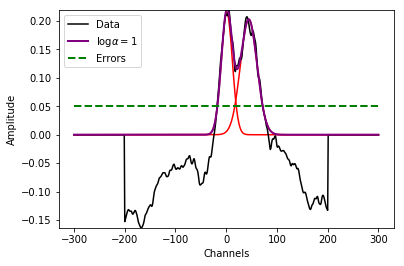

51


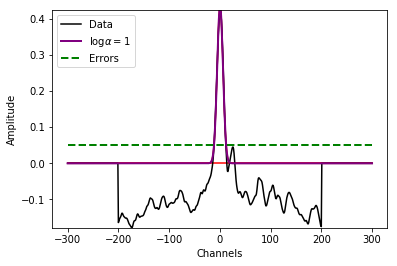

52


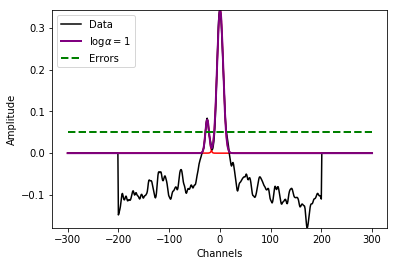

53


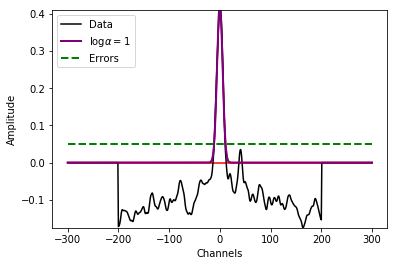

54


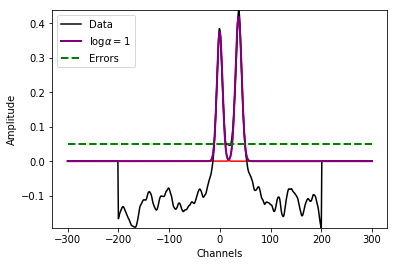

55


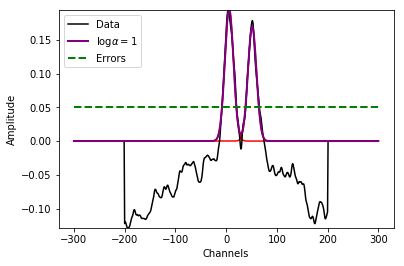

56


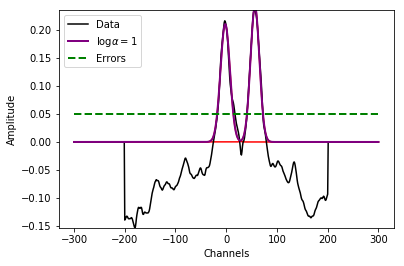

57


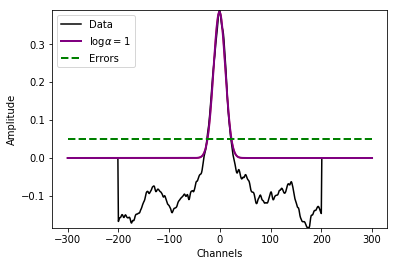

58


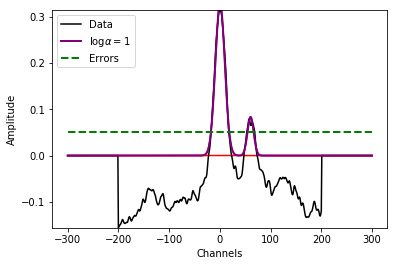

59


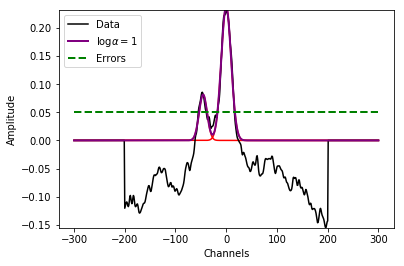

60


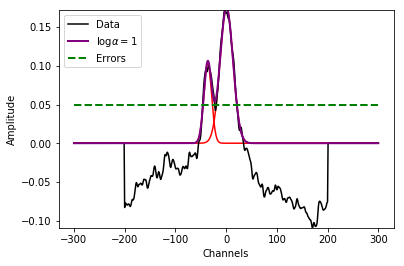

61


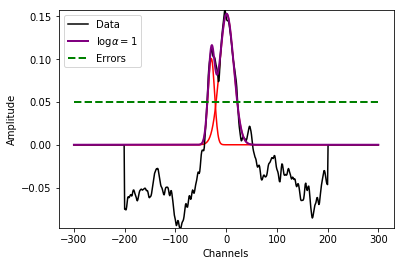

62


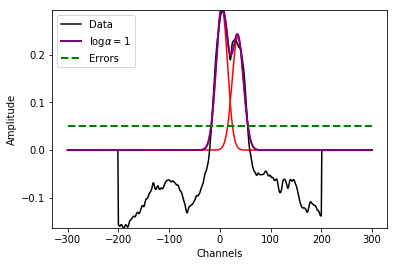

63


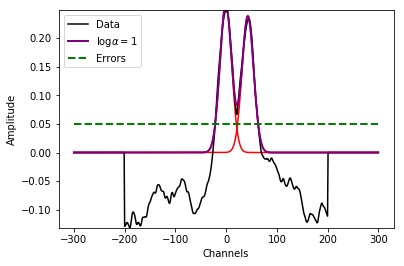

64


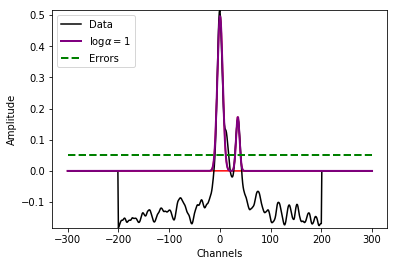

65


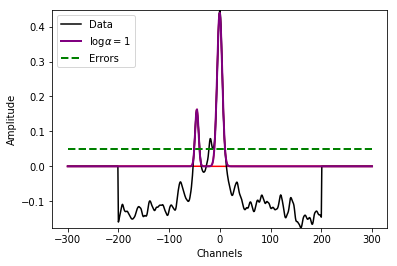

66


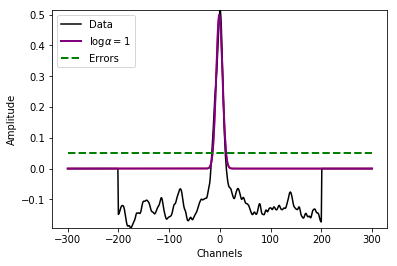

67


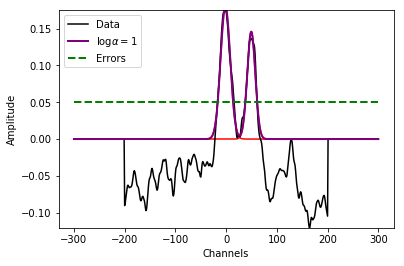

68


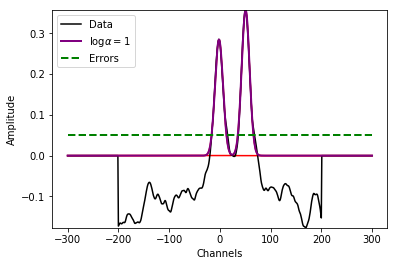

69


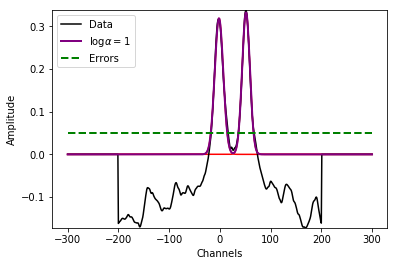

70


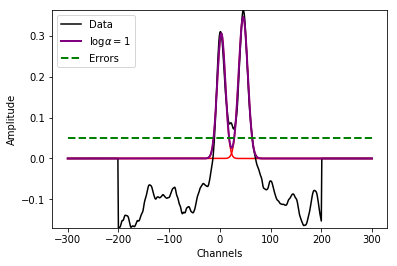

71


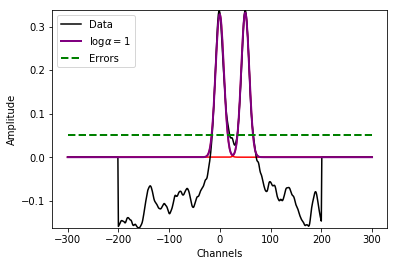

72


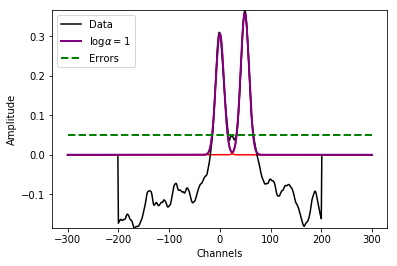

73


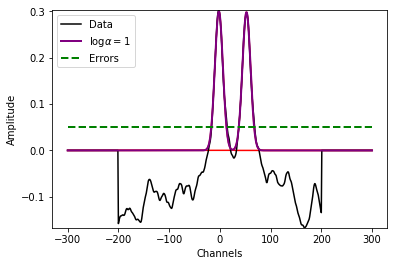

74


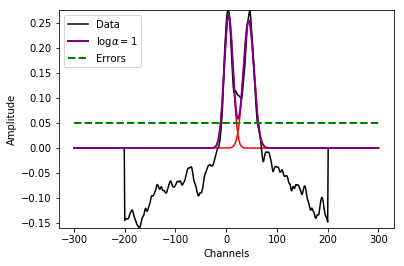

75


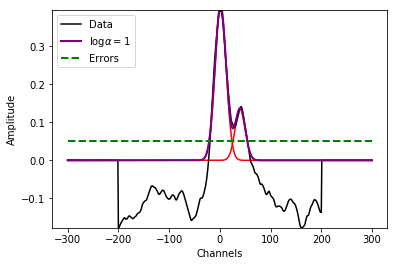

76


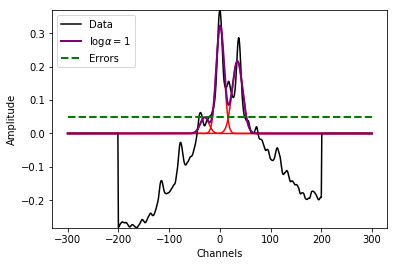

77


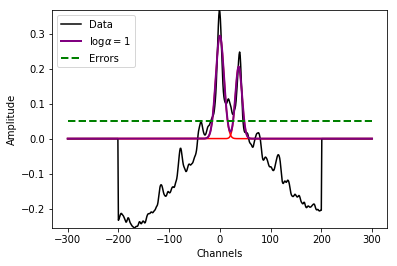

78


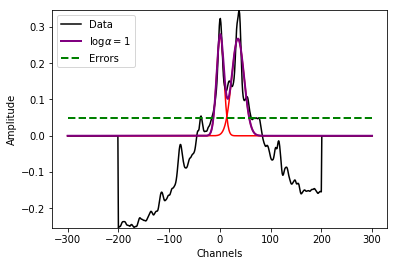

79


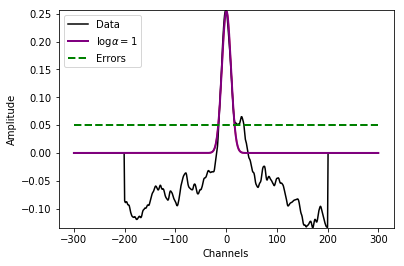

80


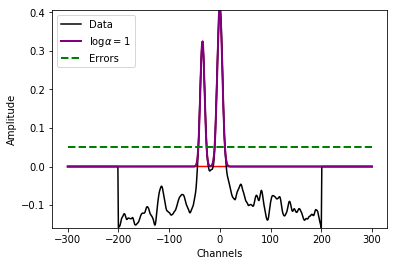

81


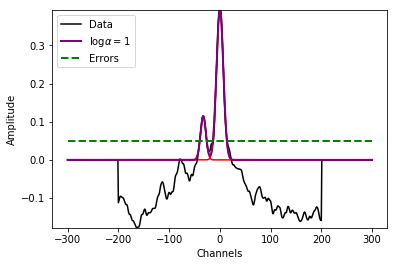

82


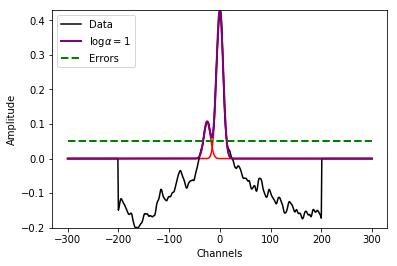

83


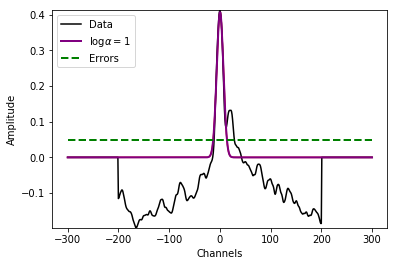

84


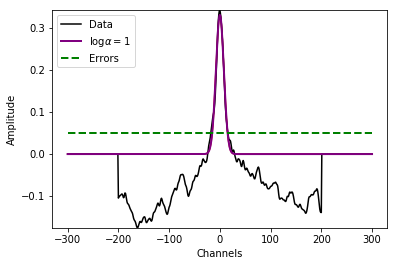

85


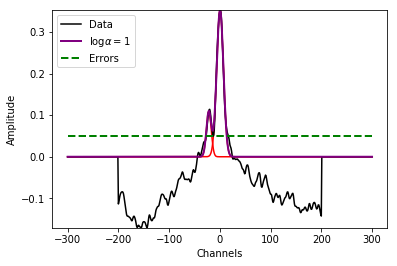

86


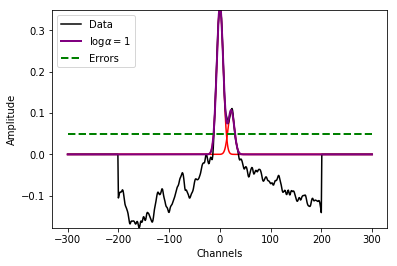

87


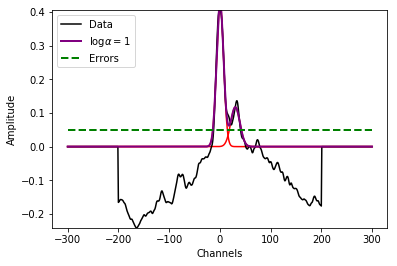

88


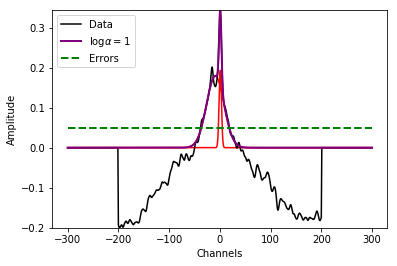

89


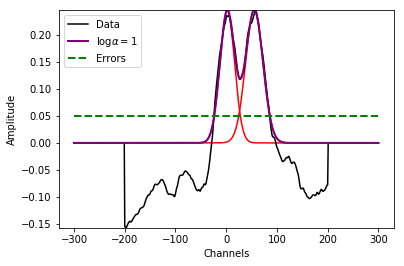

90


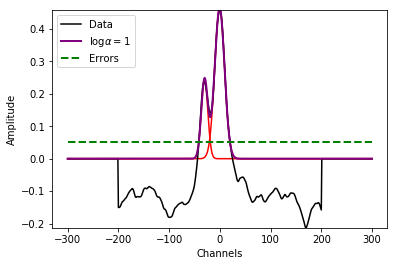

91


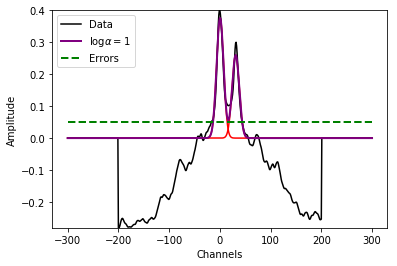

92


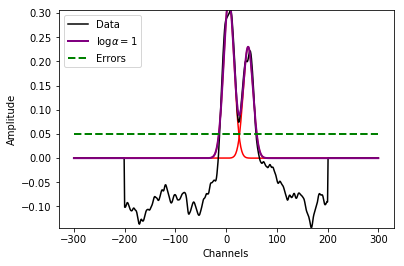

93


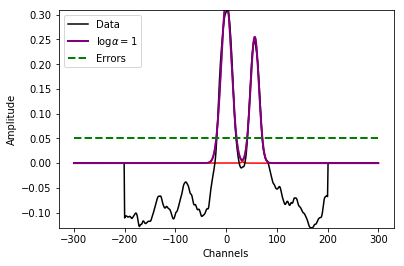

94


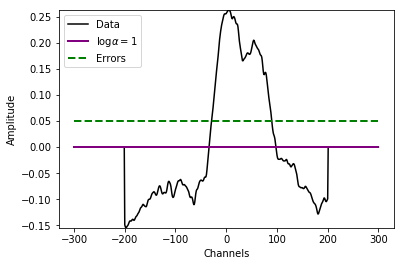

95


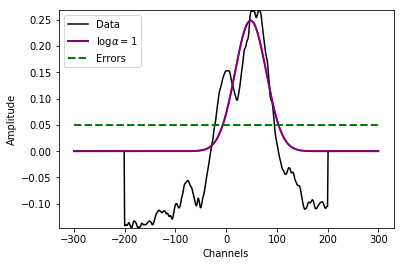

96


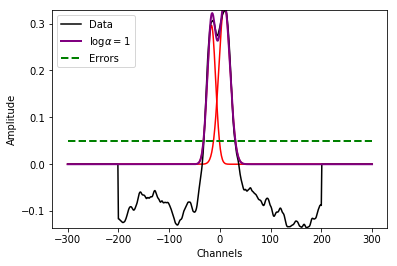

97


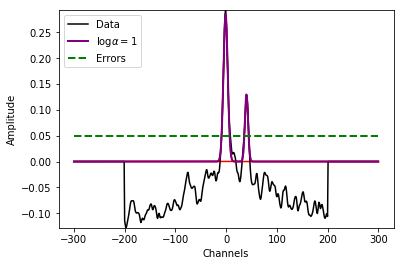

98


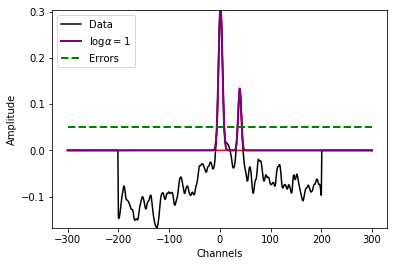

99


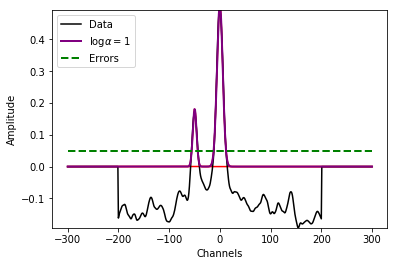

100


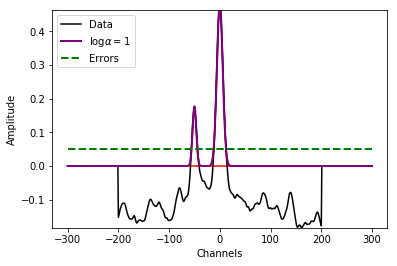

101


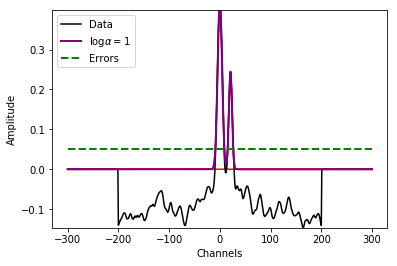

102


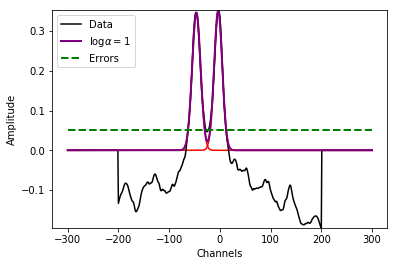

103


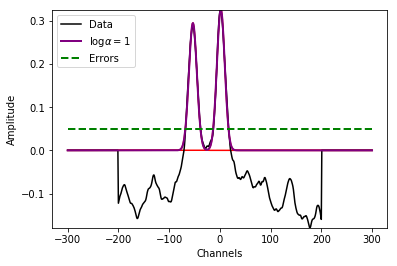

104


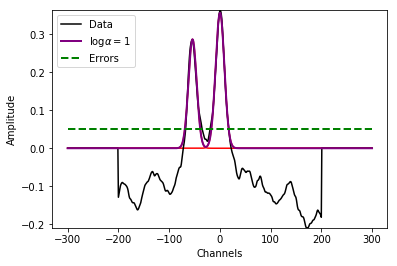

105


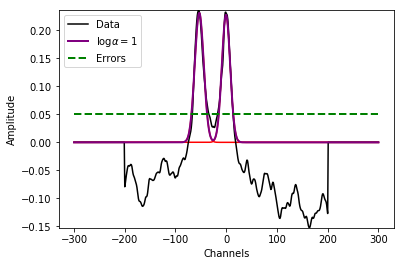

106


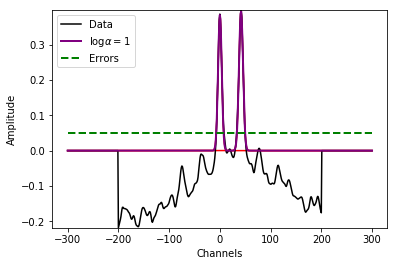

107


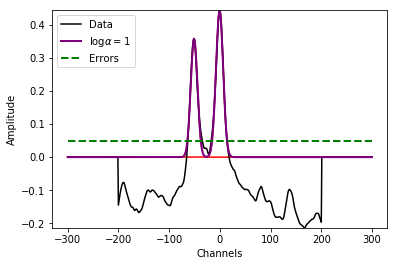

108


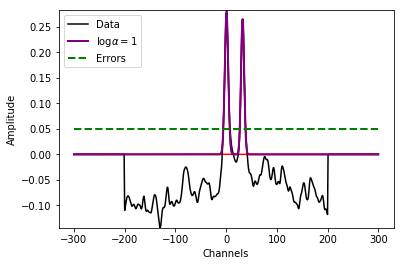

109


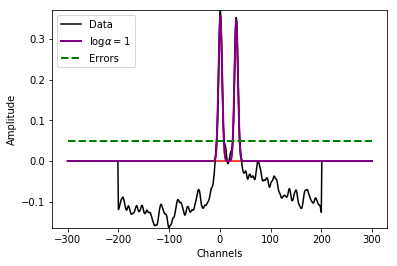

110


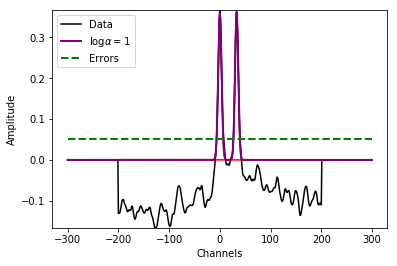

111


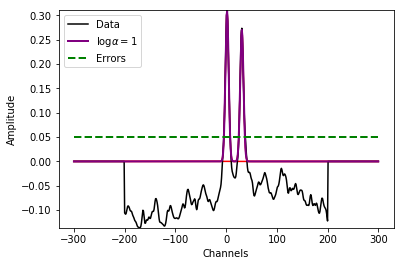

112


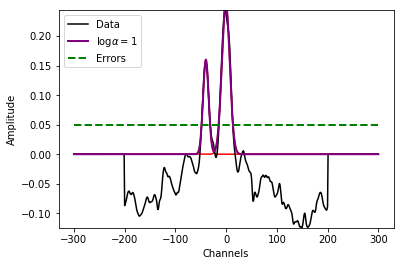

113


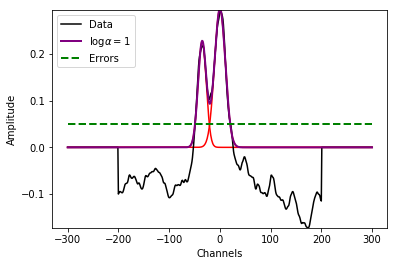

114


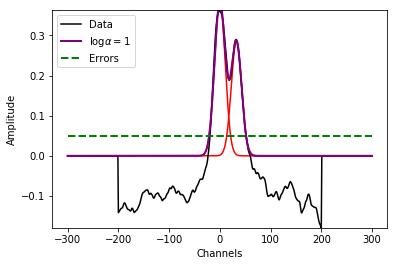

115


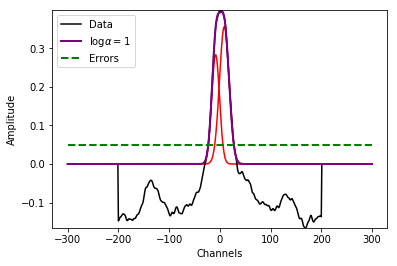

116


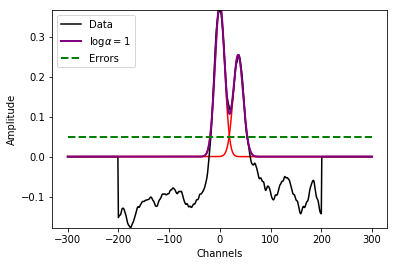

117


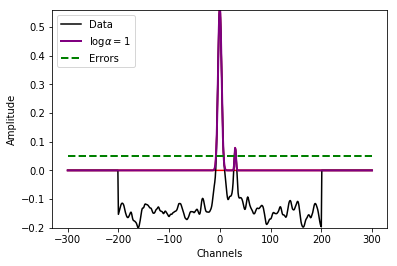

118


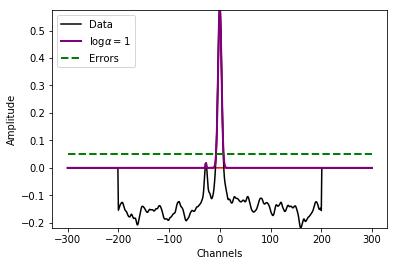

119


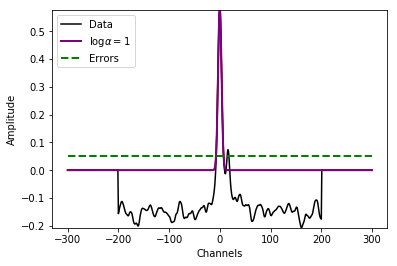

120


IndexError: list index out of range

In [9]:
# Plot GaussPy results
import numpy as np
import matplotlib.pyplot as plt
import pickle

def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)

def unravel(list):
    return np.array([i for array in list for i in array])

FILENAME_DATA_DECOMP = 'sb2_decomposed_full.pickle'
data_decomp = pickle.load(open(FILENAME_DATA_DECOMP))

chisq=np.zeros(200)
for i in range(148):
    print i+1
    spectrum = data['data_list'][i]
    chan = data['x_values'][i]
    errors = data['errors'][i]
    means_fit = data_decomp['means_fit'][i]
    amps_fit = data_decomp['amplitudes_fit'][i]
    fwhms_fit = data_decomp['fwhms_fit'][i]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    model = np.zeros(len(chan))
    for j in range(len(means_fit)):
        component = gaussian(amps_fit[j], fwhms_fit[j], means_fit[j])(chan)
        model += component
        ax.plot(chan, component, color='red', lw=1.5)
    ax.plot(chan, spectrum, label='Data', color='black', linewidth=1.5)
    ax.plot(chan, model, label = r'$\log\alpha=1.$', color='purple', linewidth=2.)
    ax.plot(chan, errors, label = 'Errors', color='green', linestyle='dashed', linewidth=2.)

    ax.set_xlabel('Channels')
    ax.set_ylabel('Amplitude')

    ax.set_ylim(np.min(spectrum),np.max(spectrum))
    ax.legend(loc=2)

    plt.show()

#print len(data_decomp['means_fit'])

In [10]:
eclbin4 = pd.read_csv('apogee_binaries_ChaseNotes4.csv')
#print eclbin4['vhelio']

In [11]:
#data_decomp is a DICTIONARY and each 'section' is a LIST
RVinLagByVisit = data_decomp['means_fit'][:]

lag = list()
for visit in range(len(RVinLagByVisit)):
    if len(RVinLagByVisit[visit]) == 0:
        lag.append(0)
    else:
        for j in range(len(RVinLagByVisit[visit])):
            lag.append(RVinLagByVisit[visit][j])
        
print lag
#print RVinLagByVisit


allNames = list()
totVHELIO = list()
period = list()
bc = list()
julian = list()
rv = list()

allNames2 = list()
totVHELIO2 = list()
period2 = list()
bc2 = list()
julian2 = list()
rv2 = list()
for i in range(len(eclbin4['apogee_id'])):
    #if eclbin4['flat'][i] == False:
        
    for j in range(0,eclbin4['numRVs'][i]):
        rv.append( lagToRV( eclbin4['RV'+str(j+1)][i], eclbin4['vhelio'][i]) )
         
        allNames.append(eclbin4['apogee_id'][i])
        totVHELIO.append(eclbin4['vhelio'][i])
        period.append(eclbin4['period'][i])
        bc.append(eclbin4['BC'][i])
        julian.append(eclbin4['juliandate'][i])
        if eclbin4['numRVs'][i] == 2:
            rv2.append( lagToRV( eclbin4['RV'+str(j+1)][i], eclbin4['vhelio'][i]) )
            allNames2.append(eclbin4['apogee_id'][i])
            totVHELIO2.append(eclbin4['vhelio'][i])
            period2.append(eclbin4['period'][i])
            bc2.append(eclbin4['BC'][i])
            julian2.append(eclbin4['juliandate'][i])

print len(rv)
print len(lag)
print rv

[1.3308137651492649, 37.255550032642944, 2.189814882572316, 19.84420218112408, -0.5635538141941623, 17.67697793468208, 1.854475261398722, -0.9742845287327591, -52.053760899025924, 0.05482098310354728, -53.468313343394875, 4.477147500018657, 0.54168037310833, 1.7080957397716343, 54.96263511733028, -3.947983150185412, 51.85821417229005, -0.46482702027356176, 41.04083964066136, 6.770736466262972, 0.9587568248723681, 1.3217123390338545, 0.074726407317395, -20.89860598580458, -0.35339517450678987, 18.55810493286054, 0.003892682994227606, -0.7072913880460606, 37.66057907556557, -1.1126819250100473, -33.93801343224582, 0.1447583462655949, 34.93884793436433, -1.9591244339326983, -0.1938689499635258, 32.46957557394872, 37.85138850437954, -2.302578310511274, -77.50209479831085, 38.21095016335061, 2.96031389803154, 39.8933841396656, -1.173433260439736, 33.310869353580394, 3.121027284093009, -0.6250173921479185, 22.729686935930456, 0.1503091791800059, 45.87863079553889, -1.5381899762420046, 22.297

In [12]:
### data frame with EBs that have 2 RV values per visit ###

print 'allNames:',  len(allNames2), '\nJD:', len(julian2), '\ntotVHELIO:', len(totVHELIO2), '\nperiod:', len(period2), '\nRV [km/s]:', len(rv2)


data2 = {'apogee_id': allNames2,
        'Julian Date': julian2,
        'VHELIO': totVHELIO2,
        'period': period2,
        #'Barycentric Correction': bc2,
        'RV [km/s]': rv2}
#       'lag/visit': totRVfit}
       #'visit_date': fakeArray}
frame2 = pd.DataFrame(data2)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(frame2)
    


allNames: 188 
JD: 188 
totVHELIO: 188 
period: 188 
RV [km/s]: 188
     Julian Date   RV [km/s]    VHELIO           apogee_id    period
0    2457295.837  -52.940336  -58.4510  2M00224443+8448486   3.51597
1    2457295.837   95.855924  -58.4510  2M00224443+8448486   3.51597
2    2457348.617  -12.619864  -94.8017  2M00315685+5743383  46.02220
3    2457348.617  -97.135246  -94.8017  2M00315685+5743383  46.02220
4    2457374.559  -22.566899  -95.7724  2M00315685+5743383  46.02220
5    2457374.559  -88.093319  -95.7724  2M00315685+5743383  46.02220
6    2457295.837   94.590525   98.6248  2M00582269+8427411   1.27273
7    2457295.837 -116.841138   98.6248  2M00582269+8427411   1.27273
8    2457556.732   98.361202   98.1342  2M00582269+8427411   1.27273
9    2457556.732 -123.184827   98.1342  2M00582269+8427411   1.27273
10   2457335.866   95.745875 -131.9290  2M03533786-0557441   0.94308
11   2457335.866 -148.276303 -131.9290  2M03533786-0557441   0.94308
12   2457336.844   83.490647 -131.3

In [13]:
### making the data frame with everything in it ###

print 'allNames:',  len(allNames), '\nJD:', len(julian), '\ntotVHELIO:', len(totVHELIO), '\nperiod:', len(period), '\nBC:', len(bc), '\nRV [km/s]:', len(rv), '\nRV [lag]:', len(lag)


data = {'apogee_id': allNames,
        'Julian Date': julian,
        'VHELIO': totVHELIO,
        'period': period,
        'Barycentric Correction': bc,
        'RV [km/s]': rv,
        'RV [lag]': lag}
#       'lag/visit': totRVfit}
       #'visit_date': fakeArray}
frame = pd.DataFrame(data)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(frame)
    


allNames: 217 
JD: 217 
totVHELIO: 217 
period: 217 
BC: 217 
RV [km/s]: 217 
RV [lag]: 217
     Barycentric Correction  Julian Date   RV [km/s]   RV [lag]    VHELIO  \
0                  11.55620  2457295.837  -52.940336   1.330814  -58.4510   
1                  11.55620  2457295.837   95.855924  37.255550  -58.4510   
2                   1.83080  2457556.732  -31.870811   2.189815  -40.9385   
3                  -7.63750  2457348.617  -12.619864  19.844202  -94.8017   
4                  -7.63750  2457348.617  -97.135246  -0.563554  -94.8017   
5                 -15.05100  2457374.559  -22.566899  17.676978  -95.7724   
6                 -15.05100  2457374.559  -88.093319   1.854475  -95.7724   
7                  11.95640  2457295.837   94.590525  -0.974285   98.6248   
8                  11.95640  2457295.837 -116.841138 -52.053761   98.6248   
9                   1.90180  2457556.732   98.361202   0.054821   98.1342   
10                  1.90180  2457556.732 -123.184827 -53.4683

In [14]:
#List Maker function
#INPUT : list with sublists (specifically data_decomp['some key'])
#OUTPUT : linear list with non-values accounted for
def listMaker(a):
    b = a[:]
    newlist = list()
    for i in range(len(b)):
        if len(b[i]) == 0:
            newlist.append(0)
        for j in range(len(b[i])):
            newlist.append(b[i][j])
    return newlist

In [15]:


meansFit = listMaker(data_decomp['means_fit'])
ampFit = listMaker(data_decomp['amplitudes_fit'])
fwhmsFit = listMaker(data_decomp['fwhms_fit'])

meansFitErr = listMaker(data_decomp['means_fit_err'])
ampFitErr = listMaker(data_decomp['amplitudes_fit_err'])
fwhmsFitErr = listMaker(data_decomp['fwhms_fit_err'])


In [16]:
cleanEBs_RVtable = pd.read_csv('cleanEBs_RVtable.csv')
#print cleanEBs_RVtable['epoch']
epoch = cleanEBs_RVtable['epoch']
component = cleanEBs_RVtable['component']

frame['epoch'] = epoch
frame['component'] = component
frame['means fit'] = meansFit
frame['amplitudes fit'] = ampFit
frame['fwhms fit'] = fwhmsFit
frame['means fit error'] = meansFitErr
frame['amplitudes fit error'] = ampFitErr
frame['fwhms fit error'] = fwhmsFitErr
#frame['means fit error'] = meansFitErr
print len(epoch)
print len(component)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(frame)
#print len(epoch)
#print len(component)

217
217
     Barycentric Correction  Julian Date   RV [km/s]   RV [lag]    VHELIO  \
0                  11.55620  2457295.837  -52.940336   1.330814  -58.4510   
1                  11.55620  2457295.837   95.855924  37.255550  -58.4510   
2                   1.83080  2457556.732  -31.870811   2.189815  -40.9385   
3                  -7.63750  2457348.617  -12.619864  19.844202  -94.8017   
4                  -7.63750  2457348.617  -97.135246  -0.563554  -94.8017   
5                 -15.05100  2457374.559  -22.566899  17.676978  -95.7724   
6                 -15.05100  2457374.559  -88.093319   1.854475  -95.7724   
7                  11.95640  2457295.837   94.590525  -0.974285   98.6248   
8                  11.95640  2457295.837 -116.841138 -52.053761   98.6248   
9                   1.90180  2457556.732   98.361202   0.054821   98.1342   
10                  1.90180  2457556.732 -123.184827 -53.468313   98.1342   
11                 14.19260  2457297.918   36.387178   4.477148   17

In [27]:
convRVerror = list()
for i in range(len(frame['means fit'])):
    convRVerror.append(errPropagate(i))
print len(convRVerror)

frame['RV error'] = convRVerror

217


In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(frame)


     Barycentric Correction  Julian Date   RV [km/s]   RV [lag]    VHELIO  \
0                  11.55620  2457295.837  -52.940336   1.330814  -58.4510   
1                  11.55620  2457295.837   95.855924  37.255550  -58.4510   
2                   1.83080  2457556.732  -31.870811   2.189815  -40.9385   
3                  -7.63750  2457348.617  -12.619864  19.844202  -94.8017   
4                  -7.63750  2457348.617  -97.135246  -0.563554  -94.8017   
5                 -15.05100  2457374.559  -22.566899  17.676978  -95.7724   
6                 -15.05100  2457374.559  -88.093319   1.854475  -95.7724   
7                  11.95640  2457295.837   94.590525  -0.974285   98.6248   
8                  11.95640  2457295.837 -116.841138 -52.053761   98.6248   
9                   1.90180  2457556.732   98.361202   0.054821   98.1342   
10                  1.90180  2457556.732 -123.184827 -53.468313   98.1342   
11                 14.19260  2457297.918   36.387178   4.477148   17.8477   

In [29]:
##Saving data frames to csv file
frame.to_csv('cleanEBs_RVtable.csv')
#frame2.to_csv('twoRV_EBs.csv')

In [16]:
"""

# Create simple Gaussian profile with added noise
# Store in format required for GaussPy

import numpy as np
import pickle

# create a function which returns the values of the Gaussian function for a
# given x
def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)

# Data properties
RMS = 0.05
NCHANNELS = 512
FILENAME = 'simple_gaussian.pickle'

# Component properties
AMP = 1.0
FWHM = 20
MEAN = 256

# Initialize
data = {}
chan = np.arange(NCHANNELS)
errors = np.ones(NCHANNELS) * RMS

spectrum = np.random.randn(NCHANNELS) * RMS
spectrum += gaussian(AMP, FWHM, MEAN)(chan)

# Enter results into AGD dataset
data['data_list'] = data.get('data_list', []) + [spectrum]
data['x_values'] = data.get('x_values', []) + [chan]
data['errors'] = data.get('errors', []) + [errors]


# Decompose simple dataset using AGD
import pickle
import gausspy.gp as gp

# Specify necessary parameters
###So I got mixed up and changed this one too but I think I changed it back?
###I don't know if I'm supposed to mess with both?
alpha1 = 1
snr_thresh = 5.
FILENAME_DATA = 'simple_gaussian.pickle'
FILENAME_DATA_DECOMP = 'simple_gaussian_decomposed.pickle'

# Load GaussPy
g = gp.GaussianDecomposer()

# Setting AGD parameters
g.set('phase', 'one')
g.set('SNR_thresh', [snr_thresh, snr_thresh])
g.set('alpha1', alpha1)

# Run GaussPy
data_decomp = g.batch_decomposition(data)
# Plot GaussPy results
###Why are we importing these again?
import numpy as np
import matplotlib.pyplot as plt
import pickle

def gaussian(amp, fwhm, mean):
    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)

def unravel(list):
    return np.array([i for array in list for i in array])

spectrum = unravel(data['data_list'])
chan = unravel(data['x_values'])
errors = unravel(data['errors'])

means_fit = unravel(data_decomp['means_fit'])
amps_fit = unravel(data_decomp['amplitudes_fit'])
fwhms_fit = unravel(data_decomp['fwhms_fit'])

fig = plt.figure()
ax = fig.add_subplot(111)

model = np.zeros(len(chan))

for j in range(len(means_fit)):
    component = gaussian(amps_fit[j], fwhms_fit[j], means_fit[j])(chan)
    model += component
    ax.plot(chan, component, color='red', lw=1.5)

ax.plot(chan, spectrum, label='Data', color='black', linewidth=1.5)
ax.plot(chan, model, label = r'$\log\alpha=1.$', color='purple', linewidth=2.)
ax.plot(chan, errors, label = 'Errors', color='green', linestyle='dashed', linewidth=2.)

ax.set_xlabel('Channels')
ax.set_ylabel('Amplitude')

ax.set_xlim(0,len(chan))
ax.set_ylim(np.min(spectrum),np.max(spectrum))
ax.legend(loc=2)

plt.show()

"""

"\n\n# Create simple Gaussian profile with added noise\n# Store in format required for GaussPy\n\nimport numpy as np\nimport pickle\n\n# create a function which returns the values of the Gaussian function for a\n# given x\ndef gaussian(amp, fwhm, mean):\n    return lambda x: amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)\n\n# Data properties\nRMS = 0.05\nNCHANNELS = 512\nFILENAME = 'simple_gaussian.pickle'\n\n# Component properties\nAMP = 1.0\nFWHM = 20\nMEAN = 256\n\n# Initialize\ndata = {}\nchan = np.arange(NCHANNELS)\nerrors = np.ones(NCHANNELS) * RMS\n\nspectrum = np.random.randn(NCHANNELS) * RMS\nspectrum += gaussian(AMP, FWHM, MEAN)(chan)\n\n# Enter results into AGD dataset\ndata['data_list'] = data.get('data_list', []) + [spectrum]\ndata['x_values'] = data.get('x_values', []) + [chan]\ndata['errors'] = data.get('errors', []) + [errors]\n\n\n# Decompose simple dataset using AGD\nimport pickle\nimport gausspy.gp as gp\n\n# Specify necessary parameters\n###So I got mixed up 